In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(42)

# Generate synthetic dataset with 5 classes
X, y = make_classification(
    n_samples=2000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=5,
    class_sep=2.0,
    random_state=42
)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


X shape: (2000, 10)
y shape: (2000,)
Unique classes: [0 1 2 3 4]


In [3]:
def one_hot(y, num_classes):
    out = np.zeros((y.shape[0], num_classes))
    out[np.arange(y.shape[0]), y] = 1
    return out

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    shift = z - np.max(z, axis=1, keepdims=True)
    exp_scores = np.exp(shift)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy(y_true, y_pred):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))


In [4]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.01):
        h1, h2, h3 = hidden_dims

        # Weight initialization
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2./input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2./h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2./h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2./h3)
        self.b4 = np.zeros((1, output_dim))

        self.lr = lr

    def forward(self, X):
        Z1 = X @ self.W1 + self.b1
        A1 = relu(Z1)

        Z2 = A1 @ self.W2 + self.b2
        A2 = relu(Z2)

        Z3 = A2 @ self.W3 + self.b3
        A3 = relu(Z3)

        Z4 = A3 @ self.W4 + self.b4
        A4 = softmax(Z4)

        cache = (X, Z1, A1, Z2, A2, Z3, A3, Z4, A4)
        return A4, cache

    def backward(self, cache, y_true):
        X, Z1, A1, Z2, A2, Z3, A3, Z4, A4 = cache
        m = X.shape[0]

        dZ4 = (A4 - y_true) / m
        dW4 = A3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * relu_derivative(Z3)
        dW3 = A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(Z2)
        dW2 = A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Update weights
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X):
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=1)


In [5]:
num_classes = 5
Y_train_oh = one_hot(y_train, num_classes)

model = NeuralNetwork(
    input_dim=10,
    hidden_dims=[64, 32, 16],
    output_dim=5,
    lr=0.01
)

epochs = 100
batch_size = 64

losses = []
accuracies = []

def get_batches(X, Y, batch_size):
    idx = np.random.permutation(X.shape[0])
    for i in range(0, len(idx), batch_size):
        batch = idx[i:i+batch_size]
        yield X[batch], Y[batch]

for epoch in range(epochs):
    for Xb, Yb in get_batches(X_train, Y_train_oh, batch_size):
        out, cache = model.forward(Xb)
        loss = cross_entropy(Yb, out)
        model.backward(cache, Yb)

    # Evaluate training
    train_probs, _ = model.forward(X_train)
    pred = np.argmax(train_probs, axis=1)
    acc = accuracy_score(y_train, pred)

    losses.append(loss)
    accuracies.append(acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f} | Acc: {acc:.4f}")


Epoch 0 | Loss: 0.9881 | Acc: 0.5275
Epoch 10 | Loss: 0.3752 | Acc: 0.8850
Epoch 20 | Loss: 0.2578 | Acc: 0.9331
Epoch 30 | Loss: 0.3022 | Acc: 0.9563
Epoch 40 | Loss: 0.1884 | Acc: 0.9619
Epoch 50 | Loss: 0.0687 | Acc: 0.9694
Epoch 60 | Loss: 0.0798 | Acc: 0.9725
Epoch 70 | Loss: 0.0570 | Acc: 0.9800
Epoch 80 | Loss: 0.0932 | Acc: 0.9819
Epoch 90 | Loss: 0.0514 | Acc: 0.9850


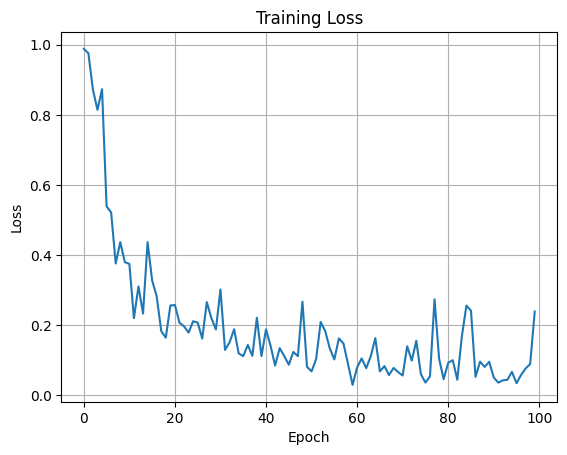

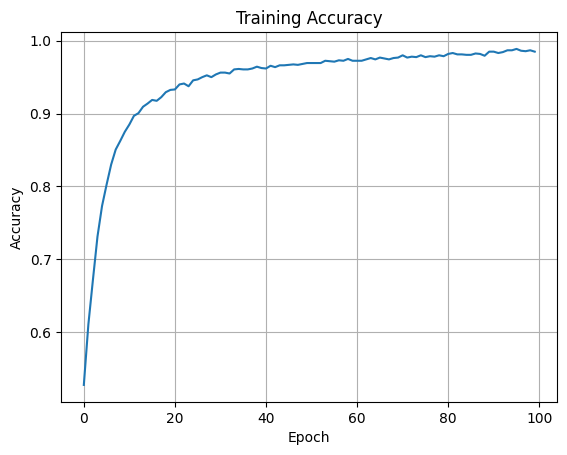

In [6]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


In [7]:
y_test_pred = model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", cm)


Test Accuracy: 0.9525

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96        79
           1       0.97      0.97      0.97        80
           2       0.95      0.91      0.93        80
           3       0.95      0.94      0.94        81
           4       0.93      0.99      0.96        80

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400


Confusion Matrix:
 [[75  1  0  0  3]
 [ 0 78  1  0  1]
 [ 1  1 73  4  1]
 [ 1  0  3 76  1]
 [ 1  0  0  0 79]]
